# **PROYECTO FINAL**
**Daniela Navas**

---
### FEATURE SELECTION

Recursive Feature Elimination (RFE)

Aplicando RFE:
 - Eliminando: SSC (importancia: 0.2664)
 - Eliminando: FR (importancia: 0.2831)
 - Eliminando: SE (importancia: 0.3011)
 - Eliminando: BW (importancia: 0.3244)

Características seleccionadas (10): ['MAV', 'RMS', 'V', 'WL', 'IEMG', 'LOGVAR', 'PF', 'TP', 'PSD', 'P2P']


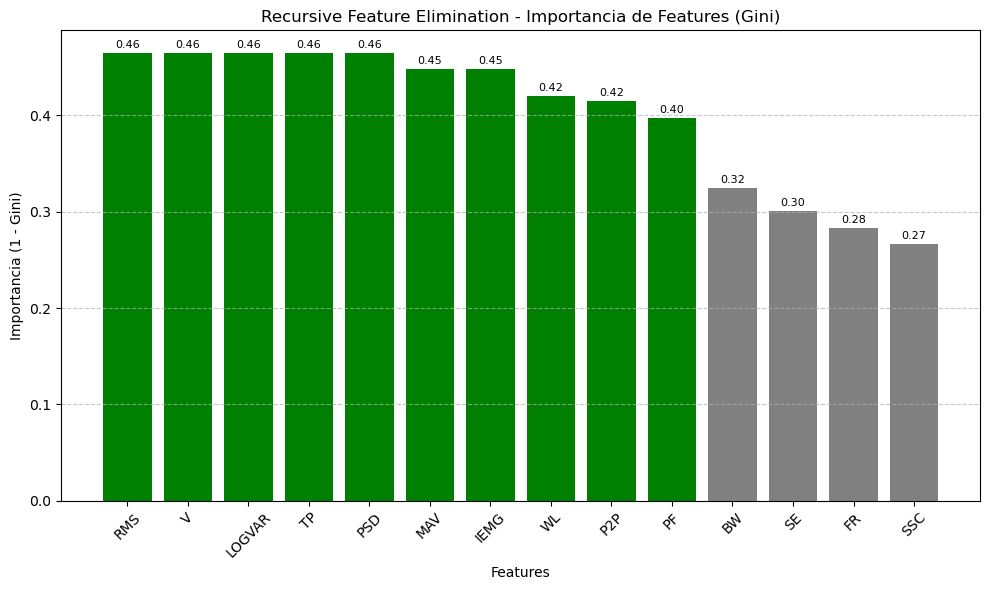

In [34]:
import random
import matplotlib.pyplot as plt

features = ["MAV", "RMS", "V", "WL", "SSC", "IEMG", "LOGVAR", "PF", "TP", "SE", "FR", "BW", "PSD", "P2P"]
clases = ["reposo", "palma", "pinza", "puno"]

# -----------------------------------------
def leer_csv(nombre_archivo):
    with open(nombre_archivo, "r") as f:
        lineas = f.readlines()
    encabezados = lineas[0].strip().split(",")
    datos = []
    for linea in lineas[1:]:
        partes = linea.strip().split(",")
        if len(partes) != len(encabezados):
            continue
        registro = {encabezados[i]: partes[i] for i in range(len(encabezados))}
        datos.append(registro)
    return datos

# -----------------------------------------
def dividir_dataset(dataset, training=0.8, semilla=42):
    random.seed(semilla)
    copia = dataset[:]
    random.shuffle(copia)
    corte = int(len(copia) * training)
    return copia[:corte], copia[corte:]

# -----------------------------------------
def convertir_a_vectores(dataset, selected_features):
    X, y = [], []
    for fila in dataset:
        X.append([float(fila[f]) for f in selected_features])
        y.append(fila["MOV"])
    return X, y

# -----------------------------------------
def calcular_importancia_rf(X, y, features):
    importancia = {}
    n = len(X)
    for i in range(len(features)):
        thresholds = sorted(set(row[i] for row in X))
        mejor_gini = float("inf")
        for t in thresholds:
            izquierda = [y[j] for j in range(n) if X[j][i] <= t]
            derecha = [y[j] for j in range(n) if X[j][i] > t]
            if not izquierda or not derecha:
                continue
            gini_izq = 1.0 - sum((izquierda.count(c)/len(izquierda))**2 for c in clases)
            gini_der = 1.0 - sum((derecha.count(c)/len(derecha))**2 for c in clases)
            gini = (len(izquierda)/n)*gini_izq + (len(derecha)/n)*gini_der
            if gini < mejor_gini:
                mejor_gini = gini
        importancia[features[i]] = 1 - mejor_gini  # Mayor importancia = menor Gini
    return importancia

# -----------------------------------------
def rfe(dataset, top_n, semilla):
    entrenamiento, _ = dividir_dataset(dataset, semilla=semilla)
    remaining_features = features[:]
    print("Aplicando RFE:")
    while len(remaining_features) > top_n:
        X_train, y_train = convertir_a_vectores(entrenamiento, remaining_features)
        importancias = calcular_importancia_rf(X_train, y_train, remaining_features)
        menos_importante = min(importancias, key=importancias.get)
        print(f" - Eliminando: {menos_importante} (importancia: {importancias[menos_importante]:.4f})")
        remaining_features.remove(menos_importante)
    print(f"\nCaracterísticas seleccionadas ({top_n}): {remaining_features}")
    return remaining_features

# -----------------------------------------
def graficar_importancias(importancias, seleccionadas):
    ordenadas = sorted(importancias.items(), key=lambda x: x[1], reverse=True)
    nombres = [x[0] for x in ordenadas]
    valores = [x[1] for x in ordenadas]
    colores = ["green" if f in seleccionadas else "gray" for f in nombres]

    plt.figure(figsize=(10, 6))
    plt.bar(nombres, valores, color=colores)
    plt.xticks(rotation=45)
    plt.title("Recursive Feature Elimination - Importancia de Features (Gini)")
    plt.ylabel("Importancia (1 - Gini)")
    plt.xlabel("Features")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, val in enumerate(valores):
        plt.text(i, val + 0.005, f"{val:.2f}", ha='center', fontsize=8)
    plt.tight_layout()
    plt.show()

# -----------------------------------------
dataset = leer_csv("dataset_completo.csv")
entrenamiento, _ = dividir_dataset(dataset, semilla=42)
X_train, y_train = convertir_a_vectores(entrenamiento, features)
importancias = calcular_importancia_rf(X_train, y_train, features)

seleccionadas = rfe(dataset, top_n=10, semilla=42)

graficar_importancias(importancias, seleccionadas)


---
## KNN


Matriz de Confusión:
               Predicho
           reposo    palma    pinza    puno  
Real
reposo      30       0       0       0   
palma        0      36       2       0   
pinza        1       2      18       4   
puno         0       1       6      20   

Métricas por clase:

Clase: reposo
  Precisión     : 0.97
  Sensibilidad  : 1.00
  Especificidad : 0.99

Clase: palma
  Precisión     : 0.92
  Sensibilidad  : 0.95
  Especificidad : 0.96

Clase: pinza
  Precisión     : 0.69
  Sensibilidad  : 0.72
  Especificidad : 0.92

Clase: puno
  Precisión     : 0.83
  Sensibilidad  : 0.74
  Especificidad : 0.96


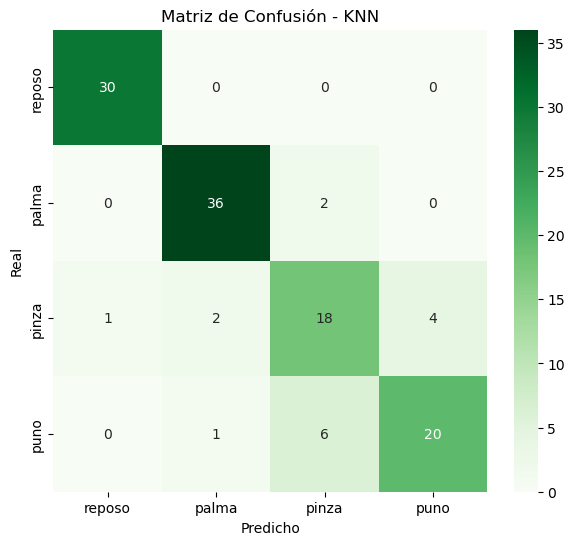

In [39]:
import random
import math
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

features = ['MAV', 'RMS', 'V', 'WL', 'IEMG', 'LOGVAR', 'PF', 'TP', 'PSD', 'P2P']
clases = ["reposo", "palma", "pinza", "puno"]

# -----------------------------------------
def leer_csv(nombre_archivo):
    with open(nombre_archivo, "r") as f:
        lineas = f.readlines()
    encabezados = lineas[0].strip().split(",")
    datos = []
    for linea in lineas[1:]:
        partes = linea.strip().split(",")
        if len(partes) != len(encabezados):
            continue
        fila = {encabezados[i]: partes[i] for i in range(len(encabezados))}
        datos.append(fila)
    return datos

# -----------------------------------------
def euclidean_distance(a, b):
    suma = 0.0
    for f in features:
        suma += (float(a[f]) - float(b[f])) ** 2
    return math.sqrt(suma)

# -----------------------------------------
def knn(train_set, instancia, k=3):
    distancias = []
    for elemento in train_set:
        dist = euclidean_distance(instancia, elemento)
        distancias.append((elemento, dist))
    distancias.sort(key=lambda x: x[1])
    vecinos = distancias[:k]
    etiquetas = [vecino[0]["MOV"] for vecino in vecinos]
    prediccion = Counter(etiquetas).most_common(1)[0][0]
    return prediccion

# -----------------------------------------
def dividir_dataset(dataset, porcentaje_entrenamiento=0.8, semilla=42):
    random.seed(semilla)
    copia = dataset[:]
    random.shuffle(copia)
    corte = int(len(copia) * porcentaje_entrenamiento)
    return copia[:corte], copia[corte:]

# -----------------------------------------
def matriz_confusion(y_verdadero, y_predicho):
    matriz = {real: {pred: 0 for pred in clases} for real in clases}
    for real, pred in zip(y_verdadero, y_predicho):
        matriz[real][pred] += 1
    return matriz

# -----------------------------------------
def metricas_clasificacion(matriz):
    print("\nMétricas por clase:")
    for clase in clases:
        TP = matriz[clase][clase]
        FP = sum(matriz[otra][clase] for otra in clases if otra != clase)
        FN = sum(matriz[clase][otra] for otra in clases if otra != clase)
        TN = sum(
            matriz[otra1][otra2]
            for otra1 in clases if otra1 != clase
            for otra2 in clases if otra2 != clase
        )
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        sensibilidad = TP / (TP + FN) if (TP + FN) > 0 else 0
        especificidad = TN / (TN + FP) if (TN + FP) > 0 else 0
        print(f"\nClase: {clase}")
        print(f"  Precisión     : {precision:.2f}")
        print(f"  Sensibilidad  : {sensibilidad:.2f}")
        print(f"  Especificidad : {especificidad:.2f}")

# -----------------------------------------
def graficar_matriz_confusion(matriz):
    matriz_np = np.array([[matriz[real][pred] for pred in clases] for real in clases])
    plt.figure(figsize=(7,6))
    sns.heatmap(matriz_np, annot=True, fmt="d", cmap="Greens",
                xticklabels=clases, yticklabels=clases)
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión - KNN")
    plt.show()

# -----------------------------------------
def ejecutar_knn(nombre_csv, k=3, seed=42):
    datos = leer_csv(nombre_csv)
    entrenamiento, prueba = dividir_dataset(datos, porcentaje_entrenamiento=0.8, semilla=seed)

    y_verdadero = []
    y_predicho = []

    for ejemplo in prueba:
        y_verdadero.append(ejemplo["MOV"])
        pred = knn(entrenamiento, ejemplo, k)
        y_predicho.append(pred)

    matriz = matriz_confusion(y_verdadero, y_predicho)

    print("\nMatriz de Confusión:")
    print("               Predicho")
    print("          ", "  ".join([f"{c:^7}" for c in clases]))
    print("Real")
    for real in clases:
        fila = " ".join([f"{matriz[real][pred]:^7}" for pred in clases])
        print(f"{real:<9} {fila}")

    metricas_clasificacion(matriz)
    graficar_matriz_confusion(matriz)


ejecutar_knn("dataset_completo.csv", k=3)


---
## SVM


Matriz de Confusión:
               Predicho
           reposo    palma    pinza    puno  
Real
reposo      30       0       0       0   
palma        0      34       1       3   
pinza        5       0      11       9   
puno         1       0       1      25   

Métricas por clase:

Clase: reposo
  Precisión     : 0.83
  Sensibilidad  : 1.00
  Especificidad : 0.93

Clase: palma
  Precisión     : 1.00
  Sensibilidad  : 0.89
  Especificidad : 1.00

Clase: pinza
  Precisión     : 0.85
  Sensibilidad  : 0.44
  Especificidad : 0.98

Clase: puno
  Precisión     : 0.68
  Sensibilidad  : 0.93
  Especificidad : 0.87


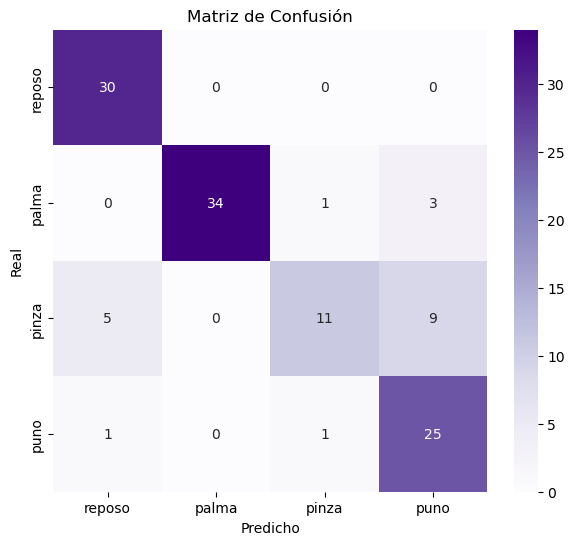

In [38]:
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

features = ['MAV', 'RMS', 'V', 'WL', 'IEMG', 'LOGVAR', 'PF', 'TP', 'PSD', 'P2P']
clases = ["reposo", "palma", "pinza", "puno"]

# -------------------------------------
def leer_csv(nombre_archivo):
    with open(nombre_archivo, "r") as f:
        lineas = f.readlines()
    encabezados = lineas[0].strip().split(",")
    datos = []
    for linea in lineas[1:]:
        partes = linea.strip().split(",")
        if len(partes) != len(encabezados):
            continue
        fila = {encabezados[i]: partes[i] for i in range(len(encabezados))}
        datos.append(fila)
    return datos

# -------------------------------------
def dividir_dataset(dataset, porcentaje_entrenamiento=0.8, semilla=42):
    random.seed(semilla)
    copia = dataset[:]
    random.shuffle(copia)
    corte = int(len(copia) * porcentaje_entrenamiento)
    return copia[:corte], copia[corte:]

# -------------------------------------
def convertir_a_vectores(dataset):
    X = []
    y = []
    for fila in dataset:
        x = [float(fila[f]) for f in features]
        X.append(x)
        y.append(fila["MOV"])
    return X, y

# -------------------------------------
def entrenar_svm_binario(X, y_binario, epochs=200, lr=0.005, lam=0.001):
    w = [0.0 for _ in range(len(X[0]))]
    b = 0.0
    for epoch in range(epochs):
        for i in range(len(X)):
            xi = X[i]
            yi = y_binario[i]
            margin = yi * (sum(w[j]*xi[j] for j in range(len(xi))) + b)
            if margin >= 1:
                for j in range(len(w)):
                    w[j] -= lr * (2 * lam * w[j])
            else:
                for j in range(len(w)):
                    w[j] -= lr * (2 * lam * w[j] - yi * xi[j])
                b += lr * yi
    return w, b

# -------------------------------------
def entrenar_svm_multiclase(X, y, clases):
    modelos = {}
    for clase in clases:
        y_bin = [1 if etiqueta == clase else -1 for etiqueta in y]
        w, b = entrenar_svm_binario(X, y_bin)
        modelos[clase] = (w, b)
    return modelos

# -------------------------------------
def predecir_svm_multiclase(X, modelos):
    predicciones = []
    for xi in X:
        scores = {}
        for clase in modelos:
            w, b = modelos[clase]
            score = sum(w[j]*xi[j] for j in range(len(xi))) + b
            scores[clase] = score
        predicciones.append(max(scores, key=scores.get))
    return predicciones

# -------------------------------------
def matriz_confusion(y_real, y_pred):
    matriz = {real: {pred: 0 for pred in clases} for real in clases}
    for real, pred in zip(y_real, y_pred):
        matriz[real][pred] += 1
    return matriz

def metricas_clasificacion(matriz):
    print("\nMétricas por clase:")
    for clase in clases:
        TP = matriz[clase][clase]
        FP = sum(matriz[otra][clase] for otra in clases if otra != clase)
        FN = sum(matriz[clase][otra] for otra in clases if otra != clase)
        TN = sum(
            matriz[otra1][otra2]
            for otra1 in clases if otra1 != clase
            for otra2 in clases if otra2 != clase
        )
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        sensibilidad = TP / (TP + FN) if (TP + FN) > 0 else 0
        especificidad = TN / (TN + FP) if (TN + FP) > 0 else 0
        print(f"\nClase: {clase}")
        print(f"  Precisión     : {precision:.2f}")
        print(f"  Sensibilidad  : {sensibilidad:.2f}")
        print(f"  Especificidad : {especificidad:.2f}")

# -------------------------------------
def graficar_matriz_confusion(matriz):
    matriz_np = np.array([[matriz[real][pred] for pred in clases] for real in clases])
    plt.figure(figsize=(7,6))
    sns.heatmap(matriz_np, annot=True, fmt="d", cmap="Purples",
                xticklabels=clases, yticklabels=clases)
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.show()

# -------------------------------------
def ejecutar_svm(nombre_csv, seed=42):
    datos = leer_csv(nombre_csv)
    train_data, test_data = dividir_dataset(datos, semilla=seed)

    X_train, y_train = convertir_a_vectores(train_data)
    X_test, y_test = convertir_a_vectores(test_data)

    modelos = entrenar_svm_multiclase(X_train, y_train, clases)
    predicciones = predecir_svm_multiclase(X_test, modelos)

    matriz = matriz_confusion(y_test, predicciones)

    print("\nMatriz de Confusión:")
    print("               Predicho")
    print("          ", "  ".join([f"{c:^7}" for c in clases]))
    print("Real")
    for real in clases:
        fila = " ".join([f"{matriz[real][pred]:^7}" for pred in clases])
        print(f"{real:<9} {fila}")

    metricas_clasificacion(matriz)
    graficar_matriz_confusion(matriz)

ejecutar_svm("dataset_completo.csv")


---
## Naive Bayes


Matriz de Confusión:
               Predicho
           reposo    palma    pinza    puno  
Real
reposo      30       0       0       0   
palma        0      23      15       0   
pinza        1       2      22       0   
puno         0       3       2      22   

Métricas por clase:

Clase: reposo
  Precisión     : 0.97
  Sensibilidad  : 1.00
  Especificidad : 0.99

Clase: palma
  Precisión     : 0.82
  Sensibilidad  : 0.61
  Especificidad : 0.94

Clase: pinza
  Precisión     : 0.56
  Sensibilidad  : 0.88
  Especificidad : 0.82

Clase: puno
  Precisión     : 1.00
  Sensibilidad  : 0.81
  Especificidad : 1.00


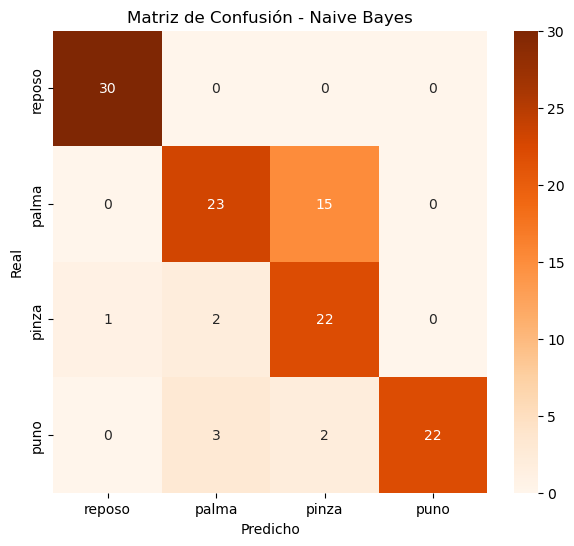

In [41]:
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

features = ['MAV', 'RMS', 'V', 'WL', 'IEMG', 'LOGVAR', 'PF', 'TP', 'PSD', 'P2P']
clases = ["reposo", "palma", "pinza", "puno"]

# -------------------------------------
def leer_csv(nombre_archivo):
    with open(nombre_archivo, "r") as f:
        lineas = f.readlines()
    encabezados = lineas[0].strip().split(",")
    datos = []
    for linea in lineas[1:]:
        partes = linea.strip().split(",")
        if len(partes) != len(encabezados):
            continue
        fila = {encabezados[i]: partes[i] for i in range(len(encabezados))}
        datos.append(fila)
    return datos

def dividir_dataset(dataset, porcentaje_entrenamiento=0.8, semilla=42):
    random.seed(semilla)
    copia = dataset[:]
    random.shuffle(copia)
    corte = int(len(copia) * porcentaje_entrenamiento)
    return copia[:corte], copia[corte:]

def convertir_a_vectores(dataset):
    X = []
    y = []
    for fila in dataset:
        x = [float(fila[f]) for f in features]
        X.append(x)
        y.append(fila["MOV"])
    return X, y

def graficar_matriz_confusion(matriz):
    matriz_np = np.array([[matriz[real][pred] for pred in clases] for real in clases])
    plt.figure(figsize=(7,6))
    sns.heatmap(matriz_np, annot=True, fmt="d", cmap="Oranges",
                xticklabels=clases, yticklabels=clases)
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión - Naive Bayes")
    plt.show()

# -------------------------------------
# Naive Bayes
def calcular_parametros(X, y):
    params = {}
    for clase in clases:
        indices = [i for i in range(len(y)) if y[i] == clase]
        clase_features = [X[i] for i in indices]
        n = len(clase_features)
        medias = [sum(f[j] for f in clase_features) / n for j in range(len(features))]
        varianzas = []
        for j in range(len(features)):
            var = sum((f[j] - medias[j])**2 for f in clase_features) / n
            varianzas.append(var if var > 1e-6 else 1e-6)  # evitar división por cero
        params[clase] = {"media": medias, "var": varianzas, "prior": n / len(y)}
    return params

def gaussiana(x, media, var):
    exp = math.exp(-(x - media)**2 / (2 * var))
    return (1 / math.sqrt(2 * math.pi * var)) * exp

def predecir(X, params):
    predicciones = []
    for xi in X:
        probs = {}
        for clase in clases:
            media = params[clase]["media"]
            var = params[clase]["var"]
            prior = params[clase]["prior"]
            prob = math.log(prior)
            for j in range(len(xi)):
                p = gaussiana(xi[j], media[j], var[j])
                prob += math.log(p if p > 1e-10 else 1e-10)  # evitar log(0)
            probs[clase] = prob
        predicciones.append(max(probs, key=probs.get))
    return predicciones

# -------------------------------------
# Métricas
def matriz_confusion(y_real, y_pred):
    matriz = {real: {pred: 0 for pred in clases} for real in clases}
    for real, pred in zip(y_real, y_pred):
        matriz[real][pred] += 1
    return matriz

def metricas_clasificacion(matriz):
    print("\nMétricas por clase:")
    for clase in clases:
        TP = matriz[clase][clase]
        FP = sum(matriz[otra][clase] for otra in clases if otra != clase)
        FN = sum(matriz[clase][otra] for otra in clases if otra != clase)
        TN = sum(
            matriz[otra1][otra2]
            for otra1 in clases if otra1 != clase
            for otra2 in clases if otra2 != clase
        )
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        sensibilidad = TP / (TP + FN) if (TP + FN) > 0 else 0
        especificidad = TN / (TN + FP) if (TN + FP) > 0 else 0
        print(f"\nClase: {clase}")
        print(f"  Precisión     : {precision:.2f}")
        print(f"  Sensibilidad  : {sensibilidad:.2f}")
        print(f"  Especificidad : {especificidad:.2f}")

# -------------------------------------
def ejecutar_naive_bayes(nombre_csv, seed=42):
    datos = leer_csv(nombre_csv)
    train_data, test_data = dividir_dataset(datos, semilla=seed)

    X_train, y_train = convertir_a_vectores(train_data)
    X_test, y_test = convertir_a_vectores(test_data)

    params = calcular_parametros(X_train, y_train)
    predicciones = predecir(X_test, params)

    matriz = matriz_confusion(y_test, predicciones)

    print("\nMatriz de Confusión:")
    print("               Predicho")
    print("          ", "  ".join([f"{c:^7}" for c in clases]))
    print("Real")
    for real in clases:
        fila = " ".join([f"{matriz[real][pred]:^7}" for pred in clases])
        print(f"{real:<9} {fila}")

    metricas_clasificacion(matriz)
    graficar_matriz_confusion(matriz)

ejecutar_naive_bayes("dataset_completo.csv", seed=42)

---
## Random Forest


Matriz de Confusión:
               Predicho
           reposo    palma    pinza    puno  
Real
reposo      30       0       0       0   
palma        0      37       1       0   
pinza        2       3      16       4   
puno         0       2       4      21   

Métricas por clase:

Clase: reposo
  Precisión     : 0.94
  Sensibilidad  : 1.00
  Especificidad : 0.98

Clase: palma
  Precisión     : 0.88
  Sensibilidad  : 0.97
  Especificidad : 0.94

Clase: pinza
  Precisión     : 0.76
  Sensibilidad  : 0.64
  Especificidad : 0.95

Clase: puno
  Precisión     : 0.84
  Sensibilidad  : 0.78
  Especificidad : 0.96


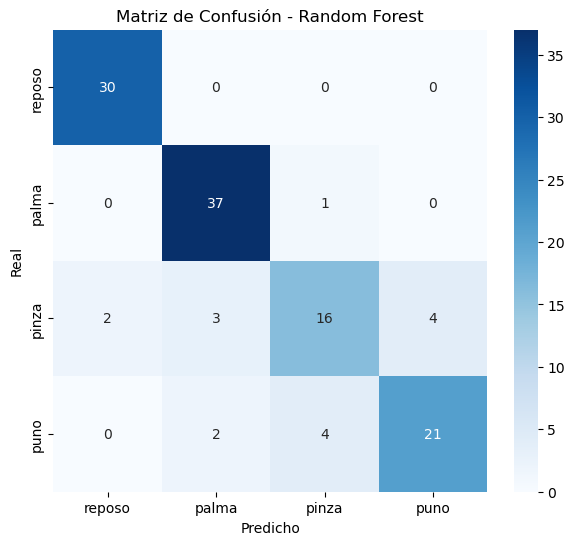

In [42]:
import random
from collections import Counter
from math import sqrt

# Características previamente seleccionadas
features = ['MAV', 'RMS', 'V', 'WL', 'IEMG', 'LOGVAR', 'PF', 'TP', 'PSD', 'P2P']
clases = ["reposo", "palma", "pinza", "puno"]

def leer_csv(nombre_archivo):
    with open(nombre_archivo, "r") as f:
        lineas = f.readlines()
    encabezados = lineas[0].strip().split(",")
    datos = []
    for linea in lineas[1:]:
        partes = linea.strip().split(",")
        if len(partes) != len(encabezados):
            continue
        registro = {encabezados[i]: partes[i] for i in range(len(encabezados))}
        datos.append(registro)
    return datos

def dividir_dataset(dataset, training=0.8, semilla=42):
    random.seed(semilla)
    copia = dataset[:]
    random.shuffle(copia)
    corte = int(len(copia) * training)
    return copia[:corte], copia[corte:]

def convertir_a_vectores(dataset, selected_features):
    X, y = [], []
    for fila in dataset:
        X.append([float(fila[f]) for f in selected_features])
        y.append(fila["MOV"])
    return X, y

def distancia_euclidiana(a, b):
    return sqrt(sum((x - y) ** 2 for x, y in zip(a, b)))

def random_forest_simplificado(X_train, y_train, X_test, k=5):
    predicciones = []
    for x in X_test:
        distancias = [(i, distancia_euclidiana(x, X_train[i])) for i in range(len(X_train))]
        distancias.sort(key=lambda x: x[1])
        vecinos = [y_train[i] for i, _ in distancias[:k]]
        predicciones.append(Counter(vecinos).most_common(1)[0][0])
    return predicciones

def graficar_matriz_confusion(matriz):
    matriz_np = np.array([[matriz[real][pred] for pred in clases] for real in clases])
    plt.figure(figsize=(7,6))
    sns.heatmap(matriz_np, annot=True, fmt="d", cmap="Blues",
                xticklabels=clases, yticklabels=clases)
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión - Random Forest")
    plt.show()

def matriz_confusion(y_real, y_pred):
    matriz = {real: {pred: 0 for pred in clases} for real in clases}
    for real, pred in zip(y_real, y_pred):
        matriz[real][pred] += 1
    return matriz

def metricas_clasificacion(matriz):
    print("\nMétricas por clase:")
    for clase in clases:
        TP = matriz[clase][clase]
        FP = sum(matriz[otra][clase] for otra in clases if otra != clase)
        FN = sum(matriz[clase][otra] for otra in clases if otra != clase)
        TN = sum(
            matriz[otra1][otra2]
            for otra1 in clases if otra1 != clase
            for otra2 in clases if otra2 != clase
        )
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        sensibilidad = TP / (TP + FN) if (TP + FN) > 0 else 0
        especificidad = TN / (TN + FP) if (TN + FP) > 0 else 0
        print(f"\nClase: {clase}")
        print(f"  Precisión     : {precision:.2f}")
        print(f"  Sensibilidad  : {sensibilidad:.2f}")
        print(f"  Especificidad : {especificidad:.2f}")

def ejecutar_rf(nombre_csv, k=5, seed=42):
    datos = leer_csv(nombre_csv)
    entrenamiento, prueba = dividir_dataset(datos, semilla=seed)
    X_train, y_train = convertir_a_vectores(entrenamiento, features)
    X_test, y_test = convertir_a_vectores(prueba, features)

    y_pred = random_forest_simplificado(X_train, y_train, X_test, k)

    matriz = matriz_confusion(y_test, y_pred)

    print("\nMatriz de Confusión:")
    print("               Predicho")
    print("          ", "  ".join([f"{c:^7}" for c in clases]))
    print("Real")
    for real in clases:
        fila = " ".join([f"{matriz[real][pred]:^7}" for pred in clases])
        print(f"{real:<9} {fila}")

    metricas_clasificacion(matriz)
    graficar_matriz_confusion(matriz)
  

# Ejecutar
ejecutar_rf("dataset_completo.csv", k=5)
